In [1]:
from numpy.random import seed
seed(8) #1

import logging

import tensorflow as tf
tf.random.set_seed(7)

import numpy as np
import pandas as pd

import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras import models
from tensorflow.keras import layers

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

2023-10-18 14:12:21.405963: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices('GPU')

2023-10-18 14:12:22.765232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:13:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 14:12:22.773465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:13:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 14:12:22.773501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:13:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from os import listdir

data_list = listdir('covid-19/four_classes/train')
print(len(data_list))

4


In [4]:
DATASET_PATH  = 'covid-19/four_classes/train'
test_dir =  'covid-19/four_classes/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10
NUM_EPOCHS    = 80
LEARNING_RATE =0.0001

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="categorical"
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="categorical"
                                                  )

Found 1119 images belonging to 4 classes.
Found 277 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1451: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


In [5]:
from tensorflow.keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.trainable = True

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

adam_optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics=['acc'])

2023-10-18 14:12:52.288994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:13:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 14:12:52.289054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:13:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 14:12:52.289070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:13:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 14:12:52.393018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:13:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 14:12:52.393065: I tensorflow/compile

In [6]:
#model=load_model('rovovk-CoroNet.keras')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 33969964 (129.59 MB)
Trainable params: 33915436 (129.38 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________
None


In [7]:
print(len(train_batches))
print(len(valid_batches))

112
28


In [8]:
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result = model.fit(
    train_batches,
    steps_per_epoch =STEP_SIZE_TRAIN,
    validation_data = valid_batches,
    validation_steps = STEP_SIZE_VALID,
    epochs= NUM_EPOCHS)

Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
2023-10-18 14:13:31.215702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-10-18 14:13:31.752160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-18 14:13:31.774001: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c86c88ec00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
202

111/111 [==============================] - 31s 145ms/step - loss: 1.0021 - acc: 0.5915 - val_loss: 0.7751 - val_acc: 0.6963
Epoch 2/80
111/111 [==============================] - 12s 105ms/step - loss: 0.5937 - acc: 0.7818 - val_loss: 0.8133 - val_acc: 0.6704
Epoch 3/80
111/111 [==============================] - 11s 99ms/step - loss: 0.5391 - acc: 0.7944 - val_loss: 0.9510 - val_acc: 0.6741
Epoch 4/80
111/111 [==============================] - 11s 98ms/step - loss: 0.4850 - acc: 0.8179 - val_loss: 0.6531 - val_acc: 0.7778
Epoch 5/80
111/111 [==============================] - 11s 96ms/step - loss: 0.4606 - acc: 0.8314 - val_loss: 0.7006 - val_acc: 0.7222
Epoch 6/80
111/111 [==============================] - 11s 97ms/step - loss: 0.4060 - acc: 0.8539 - val_loss: 0.5588 - val_acc: 0.8296
Epoch 7/80
111/111 [==============================] - 11s 99ms/step - loss: 0.4034 - acc: 0.8548 - val_loss: 0.4561 - val_acc: 0.8185
Epoch 8/80
111/111 [==============================] - 12s 104ms/step - 

In [38]:
import matplotlib.pyplot as plt

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.savefig("Loss.png")
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.savefig("Accuracy.png")
    plt.show()

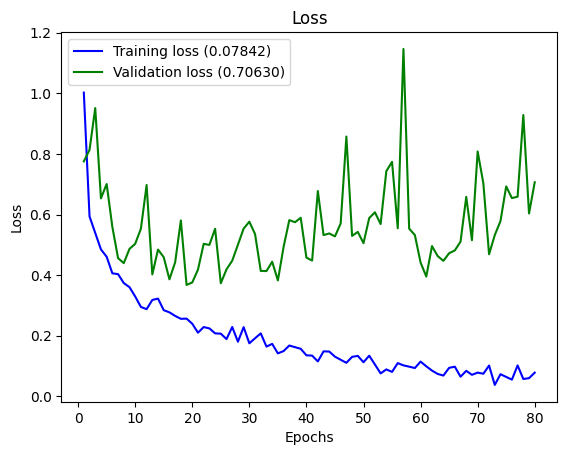

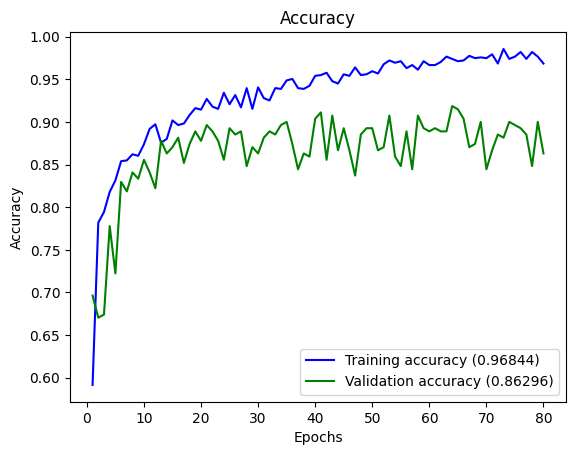

In [37]:
plot_history(result)

In [17]:
#model.save('rovovk-CoroNet.keras')

In [18]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dir =  'covid-19/combined_folds'
eval_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=10,
                                                  shuffle=False,
                                                  classes=["covid", "normal", "pneumonia_bacterial", "pneumonia_viral"],
                                                  seed=42,
                                                  class_mode="categorical")
eval_generator.reset()

Found 1414 images belonging to 4 classes.


In [19]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

  1/142 [..............................] - ETA: 13s - loss: 0.0013 - acc: 1.0000

/tmp/ipykernel_8501/3552618868.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(eval_generator,


142/142 [==============================] - 8s 55ms/step - loss: 0.3797 - acc: 0.9165
Test loss: 0.37969982624053955
Test accuracy: 0.9165487885475159


In [20]:
from sklearn.metrics import classification_report

filenames = eval_generator.filenames
eval_generator.reset()  
predict = model.predict(eval_generator,steps = np.ceil(len(eval_generator)))
predict=np.argmax(predict, axis=-1)
classes= eval_generator.classes[eval_generator.index_array]
acc=sum(predict==classes)/len(predict)

142/142 [==============================] - 8s 54ms/step


In [44]:
names=["covid", "normal", "pneumonia_bacterial", "pneumonia_viral"]

In [21]:
print(classification_report(
    y_true = classes,
    y_pred = predict,
    target_names = names
))

                     precision    recall  f1-score   support

              covid       0.99      0.98      0.98       305
             normal       0.80      1.00      0.89       375
pneumonia_bacterial       0.99      0.84      0.91       380
    pneumonia_viral       0.93      0.86      0.89       354

           accuracy                           0.92      1414
          macro avg       0.93      0.92      0.92      1414
       weighted avg       0.93      0.92      0.92      1414



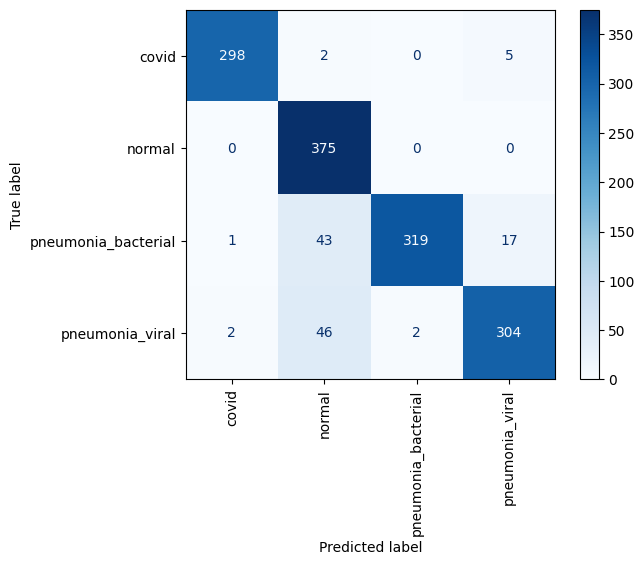

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_predictions(
    y_true = classes,
    y_pred = predict,
    display_labels = names,
    xticks_rotation = "vertical",
    cmap = plt.cm.Blues
)

In [23]:
#cm.figure_.savefig("confusion_matrix_full.png")

In [34]:
def evaluate_fold(fold_number):
    fold_test_datagen = ImageDataGenerator(rescale=1. / 255)
    fold_test_dir =  'covid-19/covid_folds/Fold' + str(fold_number)
    fold_eval_generator = test_datagen.flow_from_directory(fold_test_dir,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=10,
                                                  shuffle=False,
                                                  classes=["covid", "normal", "pneumonia_bacterial", "pneumonia_viral"],
                                                  seed=42,
                                                  class_mode="categorical")
    fold_eval_generator.reset()
    x = model.evaluate_generator(fold_eval_generator,
                           steps = np.ceil(len(fold_eval_generator)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )
    
    fold_filenames = fold_eval_generator.filenames
    
    fold_predict = model.predict(fold_eval_generator,steps = np.ceil(len(fold_eval_generator)))
    fold_predict = np.argmax(fold_predict, axis=-1)
    fold_classes = fold_eval_generator.classes[fold_eval_generator.index_array]
                                               
    return ConfusionMatrixDisplay.from_predictions(
        y_true = fold_classes,
        y_pred = fold_predict,
        display_labels = names,
        xticks_rotation = "vertical",
        cmap = plt.cm.Blues
    )

Found 277 images belonging to 4 classes.
 1/28 [>.............................] - ETA: 2s - loss: 0.0013 - acc: 1.0000

/tmp/ipykernel_8501/379387111.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(fold_eval_generator,


28/28 [==============================] - 2s 54ms/step
Found 277 images belonging to 4 classes.
 1/28 [>.............................] - ETA: 2s - loss: 1.2762 - acc: 0.8000

/tmp/ipykernel_8501/379387111.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(fold_eval_generator,


28/28 [==============================] - 1s 52ms/step
Found 284 images belonging to 4 classes.


/tmp/ipykernel_8501/379387111.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(fold_eval_generator,


29/29 [==============================] - 2s 55ms/step
Found 281 images belonging to 4 classes.


/tmp/ipykernel_8501/379387111.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(fold_eval_generator,


29/29 [==============================] - 1s 40ms/step
Found 293 images belonging to 4 classes.


/tmp/ipykernel_8501/379387111.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(fold_eval_generator,


30/30 [==============================] - 2s 54ms/step


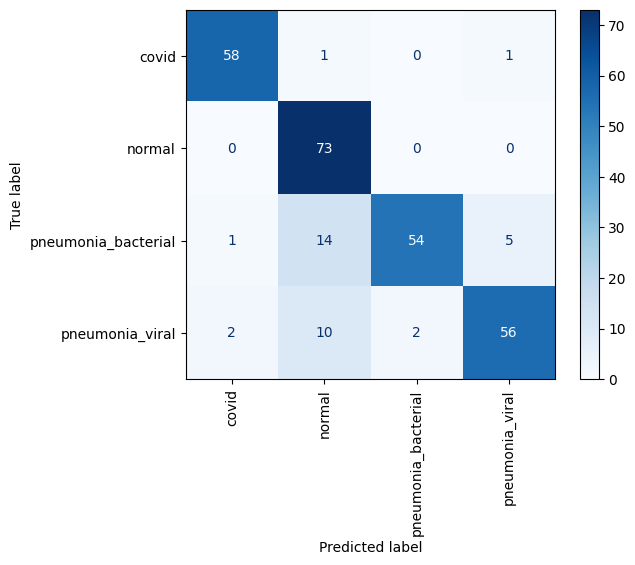

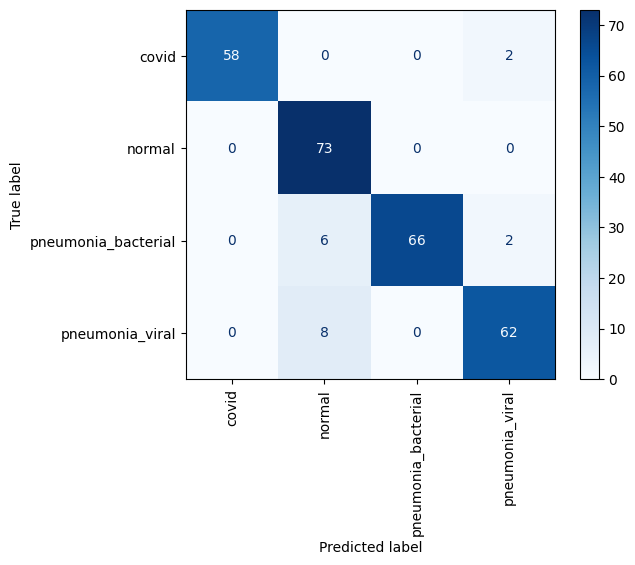

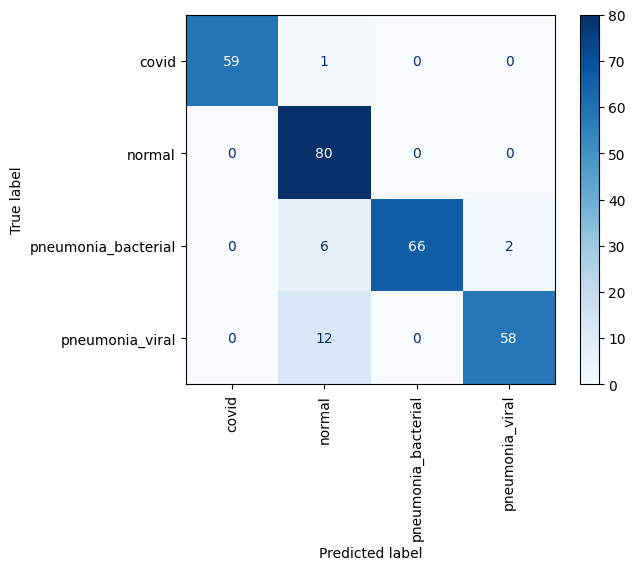

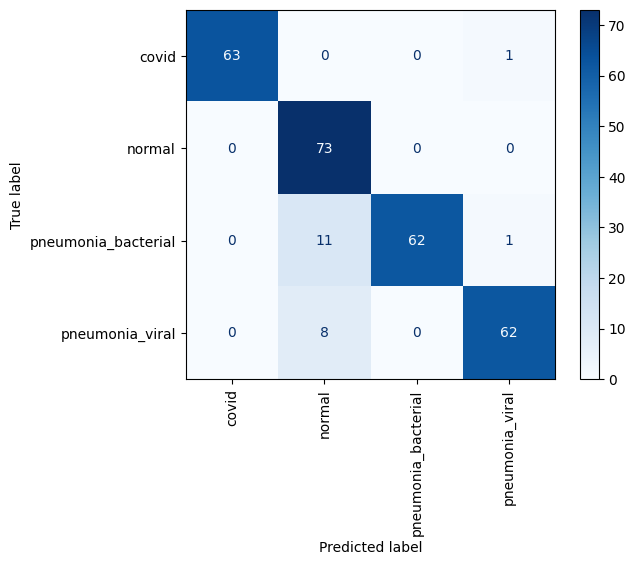

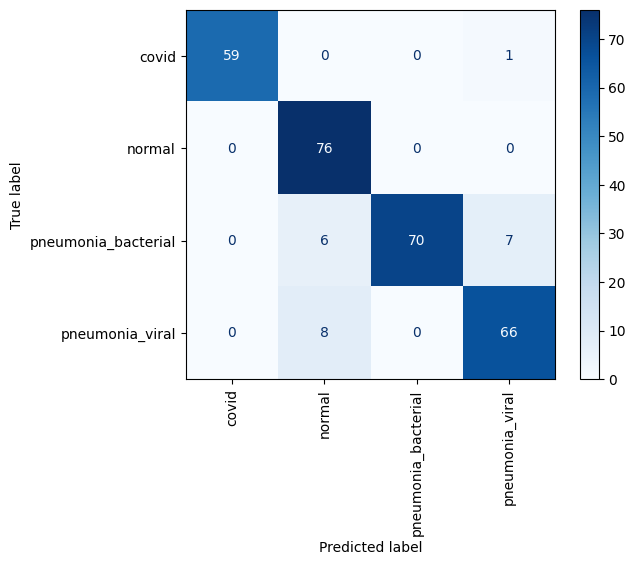

In [35]:
for fold in range(1, 6):
    fold_cm = evaluate_fold(fold)
    fold_cm.figure_.savefig(f"confusion_matrix_{str(fold)}.png")

1/1 [==============================] - 0s 18ms/step
[[9.7795586e-05 9.9646866e-01 2.9667348e-03 4.6681234e-04]]


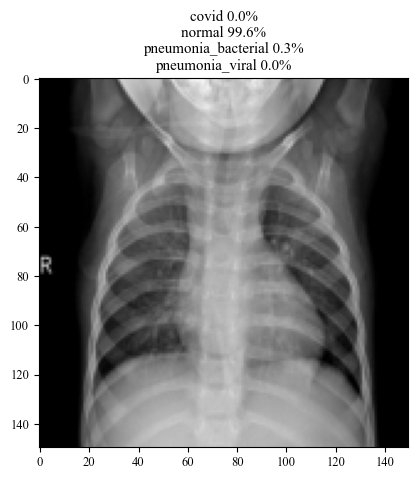

In [50]:
import cv2
from skimage import transform

img_r = cv2.imread('COVID-19_Radiography_Dataset/Normal/images/Normal-1001.png')


img1 = np.array(img_r).astype('float32')/255
img2 = transform.resize(img1, (150, 150, 3))

img = np.expand_dims(img2, axis=0)

r=model.predict(img)

p=round(r.max()*100, 3)  #to find maximum score

scores=r
print(scores)

font = {
'family': 'Times New Roman',
'size': 9,

}
plt.rc('font', **font)

plt.title(names[0] +" "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" "+ str(round(scores[0][1]*100,1))+"%"+"\n"+names[2] +" "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" "+ str(round(scores[0][3]*100,1))+"%")

plt.imshow(img2)
#plt.savefig("normal_example.png")